In [ ]:
# Setup venv and install jupyter kernel
import sys
!{sys.executable} -m venv cebra
!cebra/bin/python -m pip install --upgrade pip
!cebra/bin/python -m pip install jupyter ipykernel
!cebra/bin/python -m ipykernel install --user --name=cebra --display-name "Python (CEBRA)"

In [2]:
# Check venv has been registered as juptyer kernel
!jupyter kernelspec list

Available kernels:
  cebra      /home/jake/.local/share/jupyter/kernels/cebra
  python3    /home/jake/.local/share/jupyter/kernels/python3


In [3]:
# Restart kernel and switch to Python (CEBRA)

In [4]:
import sys
sys.executable # check that we're using the correct kernel `.../cebra/bin/python`

'/home/jake/cebra/bin/python'

In [ ]:
# !{sys.executable} -m pip install --pre 'cebra[datasets,demos]'
# !{sys.executable} -m pip install --upgrade git+https://github.com/AdaptiveMotorControlLab/cebra.git


In [ ]:
import torch
print(torch.version.cuda)
# 12.4

In [ ]:
# torch>=2.6 breaks loading cebra models, so downgrade to 2.5.0
# !{sys.executable} -m pip uninstall -y torch torchvision torchaudio
# !{sys.executable} -m pip install torch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 --index-url https://download.pytorch.org/whl/cu124

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import cebra.datasets
from cebra import CEBRA

In [2]:
import random
import copy
import torch
import numpy as np
# !mkdir data

# Set seeds for reproducibility
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(42)
monkey_pos = cebra.datasets.init('area2-bump-pos-active')
monkey_target = cebra.datasets.init('area2-bump-target-active')

def shuffle_time_independently(array):
    # Assuming array shape is (time, neurons)
    # Create an empty tensor of the same shape
    shuffled = torch.empty_like(array)
    for neuron in range(array.shape[1]):
        perm = torch.randperm(array.shape[0])
        shuffled[:, neuron] = array[perm, neuron]
    return shuffled

def shuffle_within_trials(neural, labels):
    """
    Shuffle each neuron's time series independently, but only within each contiguous
    block (trial) of identical labels.

    Args:
        neural (torch.Tensor): Neural data of shape (time, neurons)
        labels (torch.Tensor): Discrete labels of shape (time,) or (time, 1)

    Returns:
        torch.Tensor: Neural data with time points shuffled within each trial.
    """
    labels = labels.squeeze()  # Ensure labels is 1D
    neural_shuffled = neural.clone()
    
    start = 0
    for t in range(1, len(labels)):
        # When the label changes, we've reached the end of a contiguous block.
        if labels[t] != labels[t-1]:
            indices = list(range(start, t))
            # Shuffle each neuron's data independently within this block.
            for neuron in range(neural.shape[1]):
                perm = torch.randperm(len(indices))
                neural_shuffled[indices, neuron] = neural[indices, neuron][perm]
            start = t  # Update the start of the next block.
    
    # Shuffle the final contiguous block (from the last change to the end).
    indices = list(range(start, len(labels)))
    for neuron in range(neural.shape[1]):
        perm = torch.randperm(len(indices))
        neural_shuffled[indices, neuron] = neural[indices, neuron][perm]
    
    return neural_shuffled

def standardize_data(data):
    # Take log1p of neural data.
    neural_log = torch.log1p(data.neural)
    
    # Compute mean and std for each neuron (across the time dimension).
    neuron_mean = neural_log.mean(dim=0, keepdim=True)
    neuron_std = neural_log.std(dim=0, keepdim=True)
    
    # Identify neurons with little or no variance.
    valid_mask = neuron_std > 1e-6
    if valid_mask.sum() < neural_log.shape[1]:
        num_removed = neural_log.shape[1] - valid_mask.sum().item()
        print(f"{num_removed} neuron(s) removed due to near-zero variance.")
    
    # Filter out neurons with near-zero variance.
    neural_log = neural_log[:, valid_mask.squeeze()]
    neuron_mean = neuron_mean[:, valid_mask.squeeze()]
    neuron_std = neuron_std[:, valid_mask.squeeze()]
    
    # Standardize each neuron individually.
    data.neural_standardized = (neural_log - neuron_mean) / neuron_std

    # Standardize continuous_index across the feature dimension.
    ci_mean = data.continuous_index.mean(dim=0, keepdim=True)
    ci_std = data.continuous_index.std(dim=0, keepdim=True)
    data.continuous_index_standardized = (data.continuous_index - ci_mean) / ci_std

# Create a shuffled version of monkey_pos by shuffling neural data independently within each target label.
monkey_pos_shuffled = copy.deepcopy(monkey_pos)
monkey_pos_shuffled.neural = shuffle_within_trials(
    monkey_pos_shuffled.neural,
    monkey_target.discrete_index
)
# monkey_pos_shuffled.neural = shuffle_time_independently(
#     monkey_pos_shuffled.neural,
# )

# Apply standardization to both the original and the target-label–shuffled datasets.
standardize_data(monkey_pos)
standardize_data(monkey_pos_shuffled)

print("Original monkey_pos dataset standardized.")
print("Shuffled (target-based) monkey_pos dataset standardized.")


Original monkey_pos dataset standardized.
Shuffled (target-based) monkey_pos dataset standardized.


In [3]:
# for label, dataset in [("original", monkey_pos), ("shuffled", monkey_pos_shuffled)]:
#     seed_everything(42)
#     cebra_posdir3_model = CEBRA(
#         model_architecture='offset10-model',
#         batch_size=1024,
#         learning_rate=3e-4,
#         temperature=1,
#         output_dimension=3,
#         max_iterations=20000,
#         distance='cosine',
#         conditional='time_delta',
#         device='cuda_if_available',
#         verbose=True,
#         num_hidden_units=256, 
#         time_offsets=10,
#         optimizer_kwargs={"betas": (0.9, 0.95)}  # Betas from arXiv: https://arxiv.org/abs/2303.15343
#     )
#     # Fit the model using the standardized neural and continuous index data.
#     cebra_posdir3_model.fit(dataset.neural_standardized, dataset.continuous_index_standardized.numpy())
#     # Save the trained model with a label indicating if it's original or shuffled.
#     cebra_posdir3_model.save(f"./cebra_models/cebra_posdir3_model_monkey_{label}.pt")


In [4]:
posdir3_models = {}
posdir3_embeddings = {}

for label, dataset in [("original", monkey_pos), ("shuffled", monkey_pos_shuffled)]:
    # Load the corresponding model for the dataset version
    posdir3_models[label] = cebra.CEBRA.load(f"./cebra_models/cebra_posdir3_model_monkey_{label}.pt")
    # Transform the standardized neural data into embeddings
    posdir3_embeddings[label] = posdir3_models[label].transform(dataset.neural_standardized)


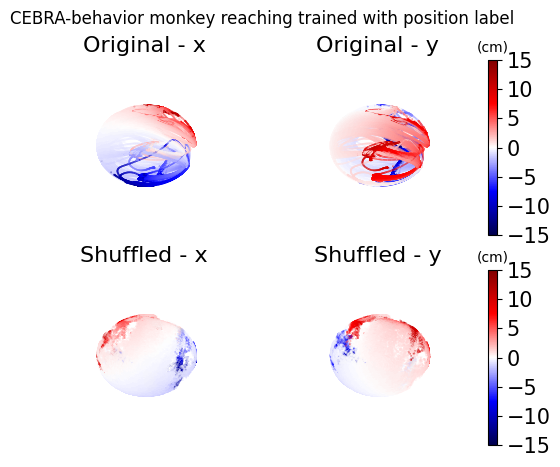

In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(6, 5))
plt.suptitle('CEBRA-behavior monkey reaching trained with position label')

# -------------------------
# Original dataset plots
# -------------------------
# "x" view: colored by continuous_index column 0
ax1 = fig.add_subplot(221, projection='3d')
ax1.set_title('Original - x', fontsize=16)
x_scatter = ax1.scatter(
    posdir3_embeddings["original"][:, 0],
    posdir3_embeddings["original"][:, 1],
    posdir3_embeddings["original"][:, 2],
    c=monkey_pos.continuous_index[:, 0],
    cmap='seismic',
    s=0.05,
    vmin=-15,
    vmax=15
)
ax1.axis('off')

# "y" view: colored by continuous_index column 1
ax2 = fig.add_subplot(222, projection='3d')
ax2.set_title('Original - y', fontsize=16)
y_scatter = ax2.scatter(
    posdir3_embeddings["original"][:, 0],
    posdir3_embeddings["original"][:, 1],
    posdir3_embeddings["original"][:, 2],
    c=monkey_pos.continuous_index[:, 1],
    cmap='seismic',
    s=0.05,
    vmin=-15,
    vmax=15
)
ax2.axis('off')

# Colorbar for the original row
cb1 = fig.colorbar(y_scatter, ax=[ax1, ax2], fraction=0.03, pad=0.05, ticks=np.linspace(-15, 15, 7))
cb1.ax.tick_params(labelsize=15)
cb1.ax.set_title("(cm)", fontsize=10)

# -------------------------
# Shuffled dataset plots
# -------------------------
# "x" view: colored by continuous_index column 0
ax3 = fig.add_subplot(223, projection='3d')
ax3.set_title('Shuffled - x', fontsize=16)
x_shuffled_scatter = ax3.scatter(
    posdir3_embeddings["shuffled"][:, 0],
    posdir3_embeddings["shuffled"][:, 1],
    posdir3_embeddings["shuffled"][:, 2],
    c=monkey_pos_shuffled.continuous_index[:, 0],
    cmap='seismic',
    s=0.05,
    vmin=-15,
    vmax=15
)
ax3.axis('off')

# "y" view: colored by continuous_index column 1
ax4 = fig.add_subplot(224, projection='3d')
ax4.set_title('Shuffled - y', fontsize=16)
y_shuffled_scatter = ax4.scatter(
    posdir3_embeddings["shuffled"][:, 0],
    posdir3_embeddings["shuffled"][:, 1],
    posdir3_embeddings["shuffled"][:, 2],
    c=monkey_pos_shuffled.continuous_index[:, 1],
    cmap='seismic',
    s=0.05,
    vmin=-15,
    vmax=15
)
ax4.axis('off')

# Colorbar for the shuffled row
cb2 = fig.colorbar(y_shuffled_scatter, ax=[ax3, ax4], fraction=0.03, pad=0.05, ticks=np.linspace(-15, 15, 7))
cb2.ax.tick_params(labelsize=15)
cb2.ax.set_title("(cm)", fontsize=10)
plt.savefig("./cebra_figures/monkey_reaching_pos_embeddings.png", bbox_inches="tight")
plt.show()


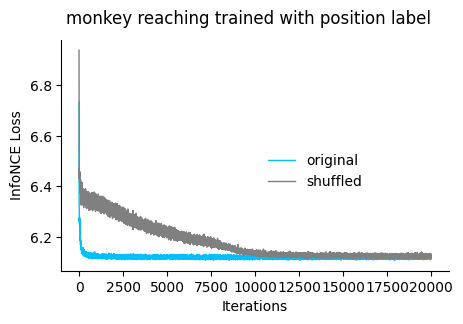

In [6]:
fig = plt.figure(figsize=(5,3))
ax = plt.subplot(111)

ax = cebra.plot_loss(posdir3_models["original"], color='deepskyblue', label='original', ax=ax)
ax = cebra.plot_loss(posdir3_models["shuffled"], color='gray', label='shuffled', ax=ax)
fig.suptitle("monkey reaching trained with position label")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Iterations')
ax.set_ylabel('InfoNCE Loss')
plt.legend(bbox_to_anchor=(0.5,0.3), frameon = False)
plt.savefig("./cebra_figures/monkey_reaching_pos_infonce.png", bbox_inches="tight")
plt.show()


In [7]:
import torch
import numpy as np
import copy

# Set seeds for reproducibility
seed_everything(42)
# Standardization function (unchanged)
def standardize_data(data):
    # Take log1p of neural data.
    neural_log = torch.log1p(data.neural)
    
    # Compute mean and std for each neuron (across the time dimension).
    neuron_mean = neural_log.mean(dim=0, keepdim=True)
    neuron_std = neural_log.std(dim=0, keepdim=True)
    
    # Identify neurons with little or no variance.
    valid_mask = neuron_std > 1e-6
    if valid_mask.sum() < neuron_std.shape[1]:
        num_removed = neuron_std.shape[1] - valid_mask.sum().item()
        print(f"{num_removed} neuron(s) removed due to near-zero variance.")
    
    # Filter out neurons with near-zero variance.
    neural_log = neural_log[:, valid_mask.squeeze()]
    neuron_mean = neuron_mean[:, valid_mask.squeeze()]
    neuron_std = neuron_std[:, valid_mask.squeeze()]
    
    # Standardize each neuron individually.
    data.neural_standardized = (neural_log - neuron_mean) / neuron_std

# Standardize the original monkey_target dataset.
standardize_data(monkey_target)

# Create a shuffled version of monkey_target by shuffling only within each label.
monkey_target_shuffled = copy.deepcopy(monkey_target)
monkey_target_shuffled.neural = shuffle_within_trials(monkey_target_shuffled.neural,
                                                      monkey_target_shuffled.discrete_index)
# Standardize the shuffled dataset's neural data as well.
standardize_data(monkey_target_shuffled)


In [8]:

# cebra_target_models = {}
# cebra_target = {}

# for label, dataset in [("original", monkey_target), ("shuffled", monkey_target_shuffled)]:
#     seed_everything(42)
#     cebra_target_models[label] = CEBRA(
#         model_architecture='offset10-model',
#         batch_size=1024,
#         learning_rate=3e-4,
#         temperature=1,
#         output_dimension=3,
#         max_iterations=20000,
#         distance='cosine',
#         conditional='time_delta', 
#         device='cuda_if_available',
#         verbose=True,
#         num_hidden_units=256, 
#         time_offsets=10,
#         optimizer_kwargs={"betas": (0.9, 0.95)}  # Betas from arXiv: https://arxiv.org/abs/2303.15343
#     )
    
#     # Train the target model using the standardized neural data and discrete labels (unchanged)
#     cebra_target_models[label].fit(dataset.neural_standardized, dataset.discrete_index.numpy())
        
#     # Optionally, save the trained model.
#     cebra_target_models[label].save(f"./cebra_models/cebra_target_model_monkey_{label}.pt")


In [9]:
cebra_target_models = {}
cebra_target_embeddings = {}

for label, dataset in [("original", monkey_target), ("shuffled", monkey_target_shuffled)]:
    # Load the corresponding target model for this dataset version
    cebra_target_models[label] = cebra.CEBRA.load(f"./cebra_models/cebra_target_model_monkey_{label}.pt")
    # Transform the standardized neural data into embeddings for the target dataset
    cebra_target_embeddings[label] = cebra_target_models[label].transform(dataset.neural_standardized)


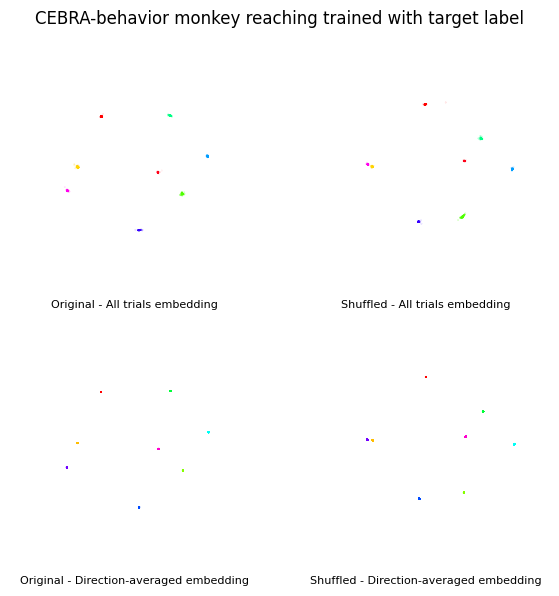

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 grid of 3D subplots.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), subplot_kw={'projection': '3d'})
fig.suptitle('CEBRA-behavior monkey reaching trained with target label')

# ---------------------------
# Top row: All trials embedding
# ---------------------------
# Original target embedding scatter plot
ax = axes[0, 0]
ax.set_title('Original - All trials embedding', fontsize=8, y=-0.1)
ax.scatter(
    cebra_target_embeddings["original"][:, 0],
    cebra_target_embeddings["original"][:, 1],
    cebra_target_embeddings["original"][:, 2],
    c=monkey_target.discrete_index,
    cmap=plt.cm.hsv,
    s=0.01
)
ax.axis('off')

# Shuffled target embedding scatter plot
ax = axes[0, 1]
ax.set_title('Shuffled - All trials embedding', fontsize=8, y=-0.1)
ax.scatter(
    cebra_target_embeddings["shuffled"][:, 0],
    cebra_target_embeddings["shuffled"][:, 1],
    cebra_target_embeddings["shuffled"][:, 2],
    c=monkey_target_shuffled.discrete_index,
    cmap=plt.cm.hsv,
    s=0.01
)
ax.axis('off')

# ---------------------------
# Bottom row: Direction-averaged embedding
# ---------------------------
# Original target direction-averaged embedding
ax = axes[1, 0]
ax.set_title('Original - Direction-averaged embedding', fontsize=8, y=-0.1)
for i in range(8):
    # Identify trials for this direction (i)
    direction_trial = (monkey_target.discrete_index == i)
    # Reshape and average across trials.
    trial_avg = cebra_target_embeddings["original"][direction_trial, :].reshape(-1, 600, 3).mean(axis=0)
    # Normalize each time point in the averaged trajectory.
    trial_avg_normed = trial_avg / np.linalg.norm(trial_avg, axis=1)[:, None]
    ax.scatter(
        trial_avg_normed[:, 0],
        trial_avg_normed[:, 1],
        trial_avg_normed[:, 2],
        color=plt.cm.hsv(i / 8),
        s=0.01
    )
ax.axis('off')

# Shuffled target direction-averaged embedding
ax = axes[1, 1]
ax.set_title('Shuffled - Direction-averaged embedding', fontsize=8, y=-0.1)
for i in range(8):
    direction_trial = (monkey_target_shuffled.discrete_index == i)
    trial_avg = cebra_target_embeddings["shuffled"][direction_trial, :].reshape(-1, 600, 3).mean(axis=0)
    trial_avg_normed = trial_avg / np.linalg.norm(trial_avg, axis=1)[:, None]
    ax.scatter(
        trial_avg_normed[:, 0],
        trial_avg_normed[:, 1],
        trial_avg_normed[:, 2],
        color=plt.cm.hsv(i / 8),
        s=0.01
    )
ax.axis('off')

plt.tight_layout()
plt.savefig("./cebra_figures/monkey_reaching_target_embeddings.png", bbox_inches="tight")
plt.show()


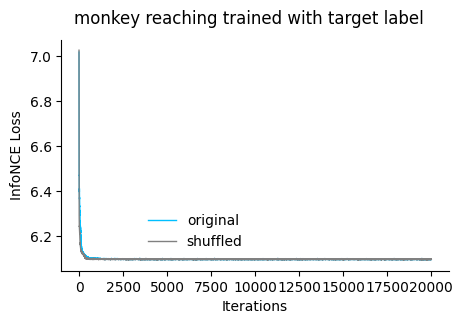

In [11]:
fig = plt.figure(figsize=(5,3))
ax = plt.subplot(111)

ax = cebra.plot_loss(cebra_target_models["original"], color='deepskyblue', label='original', ax=ax)
ax = cebra.plot_loss(cebra_target_models["shuffled"], color='gray', label='shuffled', ax=ax)
fig.suptitle('monkey reaching trained with target label')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Iterations')
ax.set_ylabel('InfoNCE Loss')
plt.legend(bbox_to_anchor=(0.5,0.3), frameon = False)
plt.savefig("./cebra_figures/monkey_reaching_target_infonce.png", bbox_inches="tight")
plt.show()
